## Implosion Year Prediction (predict implosions one year ahead)

In [6]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("1-year-rolling").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

# spark.catalog.listDatabases()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-04-09 00:25:21,937 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-04-09 00:25:25,483 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [7]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")


DataFrame[]

In [8]:
import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)

/home/ztewari/Stock-Implosion-Prediction-FYP


## Extract Yearly Time Series

In [9]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols, get_tabular_dataset_qf
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer


def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.25)
    # df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)

    
    return df



df = get_df(f'{main_dir}/data/imploded_stocks_price.csv', all_feats=True, imploded_only=False, prediction=False)


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-04-09 00:26:11,817 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


{'ff_accr_exp': 0.24735519759341887, 'ff_assets_com_eq': 0.09066693555841253, 'ff_assets_eq': 0.0136462561025822, 'ff_assets_gr': 0.07086978076919845, 'ff_assets_oth_tot': 0.054038838051543185, 'ff_assets_per_emp': 0.15823438957372254, 'ff_bnfit_loss_rsrv_tcap': 0.9792701269673213, 'ff_bps_gr': 0.11114472257934407, 'ff_capex_5ygr': 0.32089709008713774, 'ff_capex_assets': 0.027603418286319292, 'ff_capex_fix_assets': 0.27038745620005544, 'ff_capex_ps_cf': 0.05854277479475997, 'ff_cash_curr_assets': 0.2473383918593024, 'ff_cash_div_cf': 0.02515818397237137, 'ff_cash_div_covg_ratio': 0.5837723831371264, 'ff_cash_roce': 0.1392355071550413, 'ff_cash_secs_deps': 0.9007957515104154, 'ff_cf_ps_gr': 0.17077146722461703, 'ff_cf_sales': 0.08607897014461334, 'ff_claims_net_prem': 0.9887653667431328, 'ff_cogs_sales': 0.24284285798314384, 'ff_com_eq_deps': 0.89766988496475, 'ff_com_eq_gr': 0.09803624996848925, 'ff_com_eq_tcap': 0.03679615484803415, 'ff_debt_com_eq': 0.09238112043829355, 'ff_debt_entr

In [10]:
# from CreateDataset import get_fund_data_yearly

# price_data = get_fund_data_yearly(df)
# price_data = price_data.toPandas()
# price_data.to_csv('price_data.csv')

price_data = pd.read_csv('price_data.csv')

#### Grab the price/market value data

In [11]:
price_data=price_data.sort_values(by=['fsym_id','date'])
price_data['year'] = pd.to_datetime(price_data['date']).dt.year
price_data.head()

,Unnamed: 0,fsym_id,date,adj_price,Market_Value,year
0,0,B00FG1-R,2014-12-31,0.015095,248.699729,2014
1,1,B00FG1-R,2014-12-31,0.015095,248.699729,2014
2,2,B00FG1-R,2014-12-31,0.015095,248.699729,2014
3,3,B00FG1-R,2014-12-31,0.015095,248.699729,2014
4,4,B00FG1-R,2015-12-31,0.028761,531.092072,2015


In [12]:
price_df = price_data.groupby(['fsym_id', 'year'], as_index=False).first()
price_df.head()

,fsym_id,year,Unnamed: 0,date,adj_price,Market_Value
0,B00FG1-R,2014,0,2014-12-31,0.015095,248.699729
1,B00FG1-R,2015,4,2015-12-31,0.028761,531.092072
2,B00FG1-R,2016,8,2016-12-30,0.061295,1584.046059
3,B00FG1-R,2017,12,2017-12-29,0.174531,7311.973549
4,B00FG1-R,2018,16,2018-12-31,0.439903,19948.260284


In [13]:
df = df.toPandas()
df.head()

/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label
0,B00FG1-R,2012-12-31,4.682,1.248053,1.248053,NaN,0.000,NaN,NaN,78.273974,...,0.000000,NaN,0.0,NaN,NaN,NaN,0.006181,7.9,-0.000121,0
1,B00FG1-R,2013-12-31,0.499,1.016917,1.016917,27.333701,0.000,NaN,56.273777,38.851847,...,0.000000,-32.489870,0.0,NaN,NaN,NaN,0.014049,6.7,0.002644,0
2,B00FG1-R,2014-12-31,NaN,NaN,-3.274929,1213.345113,2.152,NaN,-492.849757,11.984993,...,0.294125,3.610653,0.0,-95.4447,NaN,NaN,0.006058,5.6,-0.003085,0
3,B00FG1-R,2015-12-31,NaN,NaN,-2.277646,7.348883,0.000,NaN,-48.051855,0.483800,...,1.071870,19.546902,0.0,-11.9743,NaN,NaN,0.001821,5.0,-0.001076,0
4,B00FG1-R,2016-12-31,NaN,NaN,-22.304275,76.903869,0.000,NaN,85.114102,2.179701,...,0.710952,21.835781,0.0,-22.8867,NaN,NaN,0.010414,4.7,0.002525,0


In [14]:
df['year'] = pd.to_datetime(df['date']).dt.year
# price_data['year'] = pd.to_datetime(price_data['date']).dt.year
df = pd.merge(df, price_df[['fsym_id','year','adj_price', 'Market_Value']], on=['fsym_id', 'year'], how='left')

/tmp/ipykernel_1484874/397788427.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['year'] = pd.to_datetime(df['date']).dt.year


In [15]:
df.head(100)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label,year,adj_price,Market_Value
0,B00FG1-R,2012-12-31,4.682,1.248053,1.248053,NaN,0.000,NaN,NaN,78.273974,...,NaN,NaN,NaN,0.006181,7.9,-0.000121,0,2012,NaN,NaN
1,B00FG1-R,2013-12-31,0.499,1.016917,1.016917,27.333701,0.000,NaN,56.273777,38.851847,...,NaN,NaN,NaN,0.014049,6.7,0.002644,0,2013,NaN,NaN
2,B00FG1-R,2014-12-31,NaN,NaN,-3.274929,1213.345113,2.152,NaN,-492.849757,11.984993,...,-95.4447,NaN,NaN,0.006058,5.6,-0.003085,0,2014,0.015095,248.699729
3,B00FG1-R,2015-12-31,NaN,NaN,-2.277646,7.348883,0.000,NaN,-48.051855,0.483800,...,-11.9743,NaN,NaN,0.001821,5.0,-0.001076,0,2015,0.028761,531.092072
4,B00FG1-R,2016-12-31,NaN,NaN,-22.304275,76.903869,0.000,NaN,85.114102,2.179701,...,-22.8867,NaN,NaN,0.010414,4.7,0.002525,0,2016,0.061295,1584.046059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,B0592Z-R,2013-12-31,8.324,1.619421,1.619421,-26.837465,1.024,1.558397,-25.581610,0.000000,...,-25.0722,-24.600,-24.635,0.014049,6.7,0.002644,0,2013,2.150000,134811.450000
96,B0592Z-R,2014-12-31,6.688,1.563547,1.563547,-35.430184,0.102,1.584850,-33.213295,0.000000,...,-41.5968,-23.391,-23.468,0.006058,5.6,-0.003085,0,2014,1.220000,76579.400000
97,B0592Z-R,2015-12-31,6.048,1.370986,1.370986,-36.896236,0.252,1.111222,-28.168578,0.787421,...,-16.4902,-13.774,-13.761,0.001821,5.0,-0.001076,0,2015,2.170000,136475.640000
98,B0592Z-R,2016-12-31,7.990,1.367399,1.367399,-19.058094,0.252,0.925143,-28.205349,0.046325,...,-26.1294,-22.718,-22.719,0.010414,4.7,0.002525,0,2016,1.260000,89609.940000


In [16]:
def apply_log_returns(group):
    group['log_return'] = np.log(group['adj_price'] / group['adj_price'].shift(1))
    group['log_mv_return'] = np.log(group['Market_Value'] / group['Market_Value'].shift(1))
    return group

df = df.sort_values(by=['fsym_id', 'date'])
df = df.groupby('fsym_id').apply(apply_log_returns).reset_index(drop=True)


/opt/jupyterhub/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1484874/2661831441.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('fsym_id').apply(apply_log_returns).reset_index(drop=True)


In [17]:
df.head()

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label,year,adj_price,Market_Value,log_return,log_mv_return
0,B00FG1-R,2012-12-31,4.682,1.248053,1.248053,NaN,0.000,NaN,NaN,78.273974,...,NaN,0.006181,7.9,-0.000121,0,2012,NaN,NaN,NaN,NaN
1,B00FG1-R,2013-12-31,0.499,1.016917,1.016917,27.333701,0.000,NaN,56.273777,38.851847,...,NaN,0.014049,6.7,0.002644,0,2013,NaN,NaN,NaN,NaN
2,B00FG1-R,2014-12-31,NaN,NaN,-3.274929,1213.345113,2.152,NaN,-492.849757,11.984993,...,NaN,0.006058,5.6,-0.003085,0,2014,0.015095,248.699729,NaN,NaN
3,B00FG1-R,2015-12-31,NaN,NaN,-2.277646,7.348883,0.000,NaN,-48.051855,0.483800,...,NaN,0.001821,5.0,-0.001076,0,2015,0.028761,531.092072,0.644663,0.758689
4,B00FG1-R,2016-12-31,NaN,NaN,-22.304275,76.903869,0.000,NaN,85.114102,2.179701,...,NaN,0.010414,4.7,0.002525,0,2016,0.061295,1584.046059,0.756694,1.092802


In [18]:
df.drop(['year', 'adj_price', 'Market_Value'] , inplace=True, axis=1)

In [19]:
# df=df.toPandas()
print(len(df[df['label']==1]))

667


##### The implosion number is 667, not 711, because not all the imploded stocks have fundamental data available

In [20]:
df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label,log_return,log_mv_return
152,B0CXCV-R,2015-12-31,0.892413,NaN,-0.402277,NaN,0.083579,NaN,NaN,4.249913,...,0.000,NaN,-9.097105,-9.109441,0.001821,5.0,-0.001076,0,NaN,NaN
153,B0CXCV-R,2016-12-31,2.091352,NaN,-0.117528,-12.032382,0.097546,NaN,-2631.288095,0.000000,...,0.000,NaN,-9.708269,-9.709015,0.010414,4.7,0.002525,0,NaN,NaN
154,B0CXCV-R,2017-12-31,0.715220,NaN,-0.048958,54.556835,0.097546,0.042850,-29.878111,11.395396,...,0.000,NaN,-25.652213,-25.656703,0.017494,4.1,0.002107,0,NaN,NaN
155,B0CXCV-R,2018-12-31,0.660945,1.415922,1.415922,271.038353,0.093578,0.120127,NaN,1.605581,...,0.000,-43.4143,-67.356411,-67.359557,0.005728,3.9,0.000685,0,NaN,NaN
156,B0CXCV-R,2019-12-31,0.695000,7.107744,3.800180,-21.897343,0.106000,0.093822,-90.388042,0.828991,...,0.000,-95.6397,-12.038000,-12.041000,0.009593,3.6,0.003154,0,-1.723937,-1.242311
157,B0CXCV-R,2020-12-31,1.060000,1.544423,1.427903,167.621980,0.041000,0.297342,82.302726,0.460218,...,0.039,-53.4781,-12.705000,-12.705000,0.017409,6.7,0.004685,1,-16.215971,0.664353


### IMPORTANT - Convert to Prediction Task by shifting label backwards for each stock

In [21]:
def convert_to_prediction(df):
    df_temp = spark.createDataFrame(df)
    ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
    df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
    df_temp= df_temp.filter(F.col('label').isNotNull())
    return df_temp.toPandas()

df = convert_to_prediction(df)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-04-09 00:29:39,776 WARN scheduler.TaskSetManager: Stage 20 contains a task of very large size (9239 KiB). The maximum recommended task size is 1000 KiB.
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [22]:
df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label,log_return,log_mv_return
58119,B0CXCV-R,2015-12-31,0.892413,NaN,-0.402277,NaN,0.083579,NaN,NaN,4.249913,...,0.0,NaN,-9.097105,-9.109441,0.001821,5.0,-0.001076,0,NaN,NaN
58118,B0CXCV-R,2016-12-31,2.091352,NaN,-0.117528,-12.032382,0.097546,NaN,-2631.288095,0.000000,...,0.0,NaN,-9.708269,-9.709015,0.010414,4.7,0.002525,0,NaN,NaN
58117,B0CXCV-R,2017-12-31,0.715220,NaN,-0.048958,54.556835,0.097546,0.042850,-29.878111,11.395396,...,0.0,NaN,-25.652213,-25.656703,0.017494,4.1,0.002107,0,NaN,NaN
58116,B0CXCV-R,2018-12-31,0.660945,1.415922,1.415922,271.038353,0.093578,0.120127,NaN,1.605581,...,0.0,-43.4143,-67.356411,-67.359557,0.005728,3.9,0.000685,0,NaN,NaN
58115,B0CXCV-R,2019-12-31,0.695000,7.107744,3.800180,-21.897343,0.106000,0.093822,-90.388042,0.828991,...,0.0,-95.6397,-12.038000,-12.041000,0.009593,3.6,0.003154,1,-1.723937,-1.242311


## Feature Selection

### Drop Highly Correlated Variables

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_when.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.8:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.8:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
               
df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.8:
ff_accr_exp - ff_assets_gr: 0.9978385343031658
ff_accr_exp - ff_com_eq_gr: 0.9978558813093102
ff_accr_exp - ff_debt_lt_cf: 0.9971510902327728
ff_accr_exp - ff_debt_st_x_curr_port: 0.9937294697182635
ff_accr_exp - ff_inc_tax_curr: 0.9943972056549445
ff_accr_exp - ff_inc_tax_dfd: 0.9730018774740575
ff_accr_exp - ff_int_exp_oth: 0.9980721553257696
ff_accr_exp - ff_invest_cap: 0.9988464603873759
ff_accr_exp - ff_invest_lt: 0.9210570427248246
ff_accr_exp - ff_net_inc_basic_aft_xord: 0.9950343667548887
ff_accr_exp - ff_net_inc_basic_beft_xord: 0.9951369133558915
ff_accr_exp - ff_net_inc_bef_xord_gr: 0.9979050694809406
ff_accr_exp - ff_oper_inc_aft_unusual: 0.9818839586324738
ff_accr_exp - ff_oper_inc_gr: 0.9978730171794736
ff_accr_exp - ff_sales_gr: 0.9978410277895103
ff_accr_exp - ff_sales_ps_gr: 0.9978584236561349
ff_accr_exp - ff_sga_oth: 0.999252573135207
ff_accr_exp - ff_ut_gross_inc: 0.9890683671525907
ff_accr_exp 

In [24]:
df.columns #features

Index(['fsym_id', 'date', 'ff_accr_exp', 'ff_assets_com_eq',
       'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr',
       'ff_capex_assets', 'ff_cash_curr_assets', 'ff_cash_div_cf',
       'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap',
       'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj',
       'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_eff_int_rate',
       'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_eps_basic_gr',
       'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct',
       'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth',
       'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr',
       'ff_mkt_val_public', 'ff_net_inc_per_emp', 'ff_net_mgn_gr',
       'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap',
       'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_receiv_curr_assets',
       'ff_receiv_turn', 'ff_reinvest_rate', 'ff_roic', 'ff_shs_float',
       'ff_tcap_assets', 'ff_xor

In [25]:
feats = df.drop(['fsym_id', 'date', 'label'], axis=1).columns.tolist()

In [26]:

# Assuming df is your DataFrame
null_values_per_column = df.isnull().sum()
total_rows = len(df)

print("Proportion of null values per column:")
for column, null_count in null_values_per_column.items():
    proportion_null = null_count / total_rows
    print(f"Column '{column}': {proportion_null:.2%}")


Proportion of null values per column:
Column 'fsym_id': 0.00%
Column 'date': 0.00%
Column 'ff_accr_exp': 25.87%
Column 'ff_assets_com_eq': 8.87%
Column 'ff_assets_oth_tot': 5.81%
Column 'ff_assets_per_emp': 16.30%
Column 'ff_bps_gr': 11.82%
Column 'ff_capex_assets': 2.87%
Column 'ff_cash_curr_assets': 25.87%
Column 'ff_cash_div_cf': 2.47%
Column 'ff_cash_roce': 14.20%
Column 'ff_cf_ps_gr': 17.19%
Column 'ff_cf_sales': 7.48%
Column 'ff_com_eq_tcap': 3.60%
Column 'ff_debt_entrpr_val': 15.68%
Column 'ff_dfd_tax_assets_lt': 0.00%
Column 'ff_dil_adj': 0.90%
Column 'ff_div_yld': 15.99%
Column 'ff_earn_yld': 15.84%
Column 'ff_ebit_oper_roa': 20.83%
Column 'ff_eff_int_rate': 21.95%
Column 'ff_emp_gr': 22.30%
Column 'ff_entrpr_val_sales': 19.17%
Column 'ff_eps_basic_gr': 19.27%
Column 'ff_fix_assets_com_eq': 10.33%
Column 'ff_for_assets_pct': 18.45%
Column 'ff_for_sales_pct': 11.69%
Column 'ff_gross_cf_debt': 17.94%
Column 'ff_inc_adj': 0.07%
Column 'ff_inc_sund': 0.05%
Column 'ff_intang_oth': 

### Drop columns with low variance

In [27]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df.drop(['fsym_id', 'label', 'date' ], axis=1))
mask = selector.get_support()
remaining_feats = df.drop(['fsym_id', 'label', 'date'], axis=1).columns[mask]
print(remaining_feats)

Index(['ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_oth_tot',
       'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets',
       'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr',
       'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val',
       'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld',
       'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr',
       'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq',
       'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_gross_cf_debt',
       'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth', 'ff_invest_st_tot',
       'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_mkt_val_public',
       'ff_net_inc_per_emp', 'ff_net_mgn_gr', 'ff_non_oper_exp',
       'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf',
       'ff_pfd_stk_tcap', 'ff_receiv_curr_assets', 'ff_receiv_turn',
       'ff_reinvest_rate', 'ff_roic', 'ff_shs_float', 'ff_tcap_assets',
       'ff_xord', 'ff_xord_disc',

In [28]:
df = df[remaining_feats.tolist()+['fsym_id', 'label', 'date']]

In [29]:
rows_with_null_count = df.isnull().any(axis=1).sum()

print(rows_with_null_count)

86492


In [30]:
print(len(df))

103643


In [31]:
split_date = '2019-01-01'
df=df.reset_index()
df['date'] = pd.to_datetime(df['date'])
train_df = df[df['date'] < split_date]
test_df = df[df['date'] >= split_date]

In [32]:
print(len(train_df)/(len(df)))
print(len(test_df)/len(df))

0.8236156807502677
0.17638431924973225


In [33]:
print(len(train_df[train_df['label']==1]))
print(len(test_df[test_df['label']==1]))

479
147


### Imputation
The training and tests sets are handled slightly differently. Since the test set reflects our true, real-life simulation, we should not remove any 
rows to maintain a realistic distribution of implosions. However, for training we can be more flexible, since its sole purpose is to ensure 
the model can perform best on the test set.

In [28]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

# train_df = train_df.reset_index()
# test_df = test_df.reset_index()
feats = train_df.drop(['fsym_id', 'label', 'date'], axis=1).columns.tolist()

test_df[feats] = test_df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
test_df[feats] = test_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df[feats] = test_df.groupby(['year'])[feats].fillna(test_df.median())

train_df[feats] = train_df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
train_df[feats] = train_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year




In [29]:
mask = (train_df['label'] == 0) & (train_df.isnull().any(axis=1)) #remove the null values with majority class only - this is fine to do for the training set, but not the test set

train_df = train_df[~mask]

In [30]:
null_rows = test_df[test_df.isnull().any(axis=1)]

# Print out the rows with null values
print(null_rows)

Empty DataFrame
Columns: [index, ff_accr_exp, ff_assets_com_eq, ff_assets_oth_tot, ff_assets_per_emp, ff_bps_gr, ff_capex_assets, ff_cash_curr_assets, ff_cash_div_cf, ff_cash_roce, ff_cf_ps_gr, ff_cf_sales, ff_com_eq_tcap, ff_debt_entrpr_val, ff_dfd_tax_assets_lt, ff_dil_adj, ff_div_yld, ff_earn_yld, ff_ebit_oper_roa, ff_eff_int_rate, ff_emp_gr, ff_entrpr_val_sales, ff_eps_basic_gr, ff_fix_assets_com_eq, ff_for_assets_pct, ff_for_sales_pct, ff_gross_cf_debt, ff_inc_adj, ff_inc_sund, ff_intang_oth, ff_invest_st_tot, ff_ltd_tcap, ff_min_int_tcap, ff_mkt_val_gr, ff_mkt_val_public, ff_net_inc_per_emp, ff_net_mgn_gr, ff_non_oper_exp, ff_oper_cf_fix_chrg, ff_oper_inc_tcap, ff_oper_ps_net_cf, ff_pfd_stk_tcap, ff_receiv_curr_assets, ff_receiv_turn, ff_reinvest_rate, ff_roic, ff_shs_float, ff_tcap_assets, ff_xord, ff_xord_disc, ff_eps_dil_aft_xord, ff_std_debt, ff_tang_assets_debt, ff_bk_oper_inc_oth, ff_bk_non_oper_inc, ff_commiss_inc_net, ff_cf_roic, ff_liabs_lease, ff_compr_inc, Unemployment

In [31]:
null_rows = train_df[train_df.isnull().any(axis=1)]

print(null_rows)

         index  ff_accr_exp  ff_assets_com_eq  ff_assets_oth_tot  \
19          19    70.152000          1.744019                NaN   
1417      1417     0.000000          1.960773           0.021728   
1622      1622          NaN         18.473399          31.849000   
1895      1895    32.609000          1.736805           2.078000   
1950      1950     4.876000          2.434970           0.543000   
...        ...          ...               ...                ...   
102192  102192     0.106566          1.284065           0.442392   
102329  102329     4.518000          1.489404           0.112000   
102833  102833     5.370000          1.443828           1.518000   
103333  103333     0.000000          9.914593           0.000000   
103609  103609     2.755000          2.498863           0.000000   

        ff_assets_per_emp   ff_bps_gr  ff_capex_assets  ff_cash_curr_assets  \
19               0.595847  -27.838054         5.640216            77.549887   
1417             0.075731

In [32]:
train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.loc[train_df['label'] == 1].median())) #impute the stocks that do implode as we dont want to drop these even if they have null values due to their rarity

In [33]:
train_df=train_df.dropna()

In [34]:
exclude_columns = ['fsym_id', 'label', 'year', 'date']
feats = train_df.drop(exclude_columns, axis=1).columns.tolist()
print(feats)

['index', 'ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth', 'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_mkt_val_public', 'ff_net_inc_per_emp', 'ff_net_mgn_gr', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_receiv_curr_assets', 'ff_receiv_turn', 'ff_reinvest_rate', 'ff_roic', 'ff_shs_float', 'ff_tcap_assets', 'ff_xord', 'ff_xord_disc', 'ff_eps_dil_aft_xord', 'ff_std_debt', 'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_bk_non_

In [35]:
print(len(train_df.columns))
print(len(train_df['fsym_id']))
print(len(test_df['fsym_id']))
print(len(test_df[test_df['label']==1]))
print(len(train_df[train_df['label']==1]))

66
46675
18281
147
414


In [36]:
print(len(test_df)/(len(test_df)+len(train_df)))

0.28143666481926227


### Testing whether lags work

In [37]:
# print(feats)
# def create_lags(group):
#     # for col in feats:
#     #     group[f'{col}_lag1'] = group[col].shift(1).fillna(method='bfill')
#     #     # group[f'{col}_lag2'] = group[col].shift(2).fillna(method='bfill')
#     # return group
#     num_rows = len(group)
#     for col in feats:
#         if num_rows == 1:  # If only one row in the group, set lagged feature to original value
#             group[f'{col}_lag1'] = group[col]
#             # group[f'{col}_lag2'] = group[col]
#         else:
#             group[f'{col}_lag1'] = group[col].shift(1).fillna(method='bfill')
#             # group[f'{col}_lag2'] = group[col].shift(2).fillna(method='bfill')
#     return group

# train_df = train_df.sort_values(by=['fsym_id', 'date'])
# test_df = test_df.sort_values(by=['fsym_id', 'date'])
# train_df2 = train_df.groupby('fsym_id').apply(create_lags).reset_index(drop=True)
# test_df2 = test_df.groupby('fsym_id').apply(create_lags).reset_index(drop=True)

In [39]:
# train_df2[['fsym_id', 'date', 'ff_tang_assets_debt', 'ff_tang_assets_debt_lag1', 'ff_tang_assets_debt_lag2']].head(100)

In [40]:
# null_rows = train_df2[train_df2.isnull().any(axis=1)]

# print(null_rows)

In [41]:
# test_df2.head()

### Testing differencing

In [ ]:
# train_df = pd.read_csv('train_df.csv')
# test_df=pd.read_csv('test_df.csv')
# print("Files read")

In [43]:
# train_df.drop(['Unnamed: 0', 'index'], axis=1,inplace=True)
# test_df.drop(['Unnamed: 0', 'index'], axis=1,inplace=True)
train_df.head()

,index,ff_accr_exp,ff_assets_com_eq,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,...,ff_cf_roic,ff_liabs_lease,ff_compr_inc,Unemployment_Rate,log_return,log_mv_return,fsym_id,label,date,year
3,3,16.412,1.205895,3.439,1.230111,79.509394,7.637973,86.069026,0.0,18.571861,...,14.742053,0.0,25.208,3.9,0.541789,0.696588,BHZYXG-R,0,2018-12-31,2018
4,4,38.969,1.563511,4.193,0.752473,-2.043736,0.810028,84.431610,0.0,-1.489816,...,-1.509609,0.0,-15.567,4.1,-0.048163,-0.026087,BHZYXG-R,0,2017-12-31,2017
5,5,45.765,1.601873,2.465,1.481507,-3.935307,0.668809,81.148270,0.0,2.273441,...,-6.130346,0.0,-18.010,4.7,0.538370,0.564466,BHZYXG-R,0,2016-12-31,2016
6,6,45.989,1.601555,3.181,1.805508,-19.847899,1.186107,85.969726,0.0,-11.700086,...,8.473203,0.0,-39.865,5.0,-0.430568,-0.334700,BHZYXG-R,0,2015-12-31,2015
7,7,6.502,1.067698,0.028,2.682875,192.886340,5.107045,91.598109,0.0,-47.422429,...,-79.587784,0.0,20.186,5.6,0.143155,0.301926,BHZYXG-R,0,2014-12-31,2014


In [44]:
feats = train_df.drop(['date', 'fsym_id', 'label'], axis=1).columns.tolist()

In [ ]:
# def apply_diff(group):
#     group[f'return'] =group['adj_price'].diff().fillna(method='bfill')
#     group[f'mv_return'] =group['Market_Value'].diff().fillna(method='bfill')
#     return group

# train_df = train_df.sort_values(by=['fsym_id', 'date'])
# test_df = test_df.sort_values(by=['fsym_id', 'date'])
# train_df3 = train_df.groupby('fsym_id').apply(apply_diff).reset_index(drop=True)
# test_df3 = test_df.groupby('fsym_id').apply(apply_diff).reset_index(drop=True)

In [45]:
temp_spark_df = spark.createDataFrame(train_df)
temp_spark_df.createOrReplaceTempView('temp_table')

q = """SELECT t.*, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code"""
df_with_industry = spark.sql(q)
train_df = df_with_industry.toPandas()
one_hot_encoded = pd.get_dummies(train_df['factset_industry_desc'])

# train_df = pd.concat([train_df, one_hot_encoded], axis=1)

2024-03-24 20:38:22,424 WARN scheduler.TaskSetManager: Stage 26 contains a task of very large size (1734 KiB). The maximum recommended task size is 1000 KiB.


In [46]:
grouped_industry = train_df.groupby('factset_industry_desc').size().sort_values(ascending=False)
top_10 = grouped_industry.head(10).index.tolist()
for col in one_hot_encoded.columns.tolist():
    if col not in top_10:
        one_hot_encoded.drop(col, axis=1, inplace=True)
train_df = pd.concat([train_df, one_hot_encoded], axis=1)

In [47]:
temp_spark_df = spark.createDataFrame(test_df)
temp_spark_df.createOrReplaceTempView('temp_table')

q = """SELECT t.*, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code"""
df_with_industry = spark.sql(q)
test_df = df_with_industry.toPandas()
one_hot_encoded = pd.get_dummies(test_df['factset_industry_desc'])

# test_df = pd.concat([test_df, one_hot_encoded], axis=1)

2024-03-24 20:38:42,119 WARN scheduler.TaskSetManager: Stage 32 contains a task of very large size (1162 KiB). The maximum recommended task size is 1000 KiB.


In [48]:
for col in one_hot_encoded.columns.tolist():
    if col not in top_10:
        one_hot_encoded.drop(col, axis=1, inplace=True)
test_df = pd.concat([test_df, one_hot_encoded], axis=1)

In [49]:
train_df.drop('factset_industry_desc', axis=1, inplace=True)
test_df.drop('factset_industry_desc', axis=1, inplace=True)

In [ ]:
# import os
# import pandas as pd

# train_file = 'data_when/train_df_when.csv'
# test_file = 'data_when/test_df_when.csv'

# # Check if the files exist
# if not (os.path.exists(train_file) and os.path.exists(test_file)):
#     # Write DataFrames to files
#     train_df.to_csv(train_file, index=False)
#     test_df.to_csv(test_file, index=False)
# else:
#     # Read DataFrames from existing files
#     print("works")
#     train_df = pd.read_csv(train_file, index_col=False)
#     test_df = pd.read_csv(test_file, index_col=False)

In [50]:
train_df.head()

,index,ff_accr_exp,ff_assets_com_eq,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,...,Biotechnology,Electric Utilities,Industrial Machinery,Information Technology Services,Medical Specialties,Miscellaneous Commercial Services,Packaged Software,Pharmaceuticals: Major,Semiconductors,Specialty Stores
0,95504,350.0040,2.048384,262.552,0.623172,-3.926782,1.624211,8.161316,33.989332,5.263020,...,0,0,0,0,0,0,0,0,0,0
1,95505,405.3610,1.871760,220.568,0.617808,14.293051,1.241259,14.835924,-79.199050,-2.267558,...,0,0,0,0,0,0,0,0,0,0
2,95506,442.3715,2.395890,263.557,0.635017,6.513981,1.312727,11.455810,10.289842,18.365120,...,0,0,0,0,0,0,0,0,0,0
3,95507,552.9590,2.319687,92.216,0.578073,-2.226371,1.604504,10.790848,9.841963,18.533748,...,0,0,0,0,0,0,0,0,0,0
4,95508,339.8850,2.311118,82.835,0.594832,13.056933,1.090462,10.374697,10.321783,17.468640,...,0,0,0,0,0,0,0,0,0,0


In [51]:
train_df.drop([ 'index' ], axis=1, inplace=True)
test_df.drop([ 'index' ], axis=1, inplace=True)

# train_df2.drop([ 'index' ], axis=1, inplace=True)
# test_df2.drop([ 'index' ], axis=1, inplace=True)



In [52]:
train_df = train_df.sort_values(by='date')
test_df=test_df.sort_values(by='date')

# train_df2 = train_df2.sort_values(by='date')
# test_df2=test_df2.sort_values(by='date')

In [ ]:
# test_df.drop('General Government', axis=1, inplace=True)

In [53]:
feats = train_df.drop(['fsym_id', 'label','date'], axis=1).columns.tolist()

In [54]:
rows_with_null_adj_price = train_df[train_df['log_return'].isnull()]
print(rows_with_null_adj_price[['fsym_id', 'date','log_return', 'log_mv_return', 'label']])

Empty DataFrame
Columns: [fsym_id, date, log_return, log_mv_return, label]
Index: []


In [55]:
train_df.head()

,ff_accr_exp,ff_assets_com_eq,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,ff_cf_ps_gr,...,Biotechnology,Electric Utilities,Industrial Machinery,Information Technology Services,Medical Specialties,Miscellaneous Commercial Services,Packaged Software,Pharmaceuticals: Major,Semiconductors,Specialty Stores
45895,1304.000000,1.384086,90.000000,0.084980,35.616740,15.110357,2.660407,9.239130,26.184716,26.423849,...,0,0,0,0,0,0,0,0,0,0
38717,4.035215,1.366157,0.257178,0.117273,-0.034006,2.148558,33.099067,34.984328,6.057222,54.677865,...,0,0,0,0,0,0,0,0,0,0
41055,0.638668,2.257019,0.169365,0.026522,12.947684,3.017304,2.004124,0.000000,15.456981,-464.794484,...,0,0,0,0,0,0,0,0,0,0
21218,10.917000,2.584752,3.084000,0.117237,5.759355,5.146457,1.291388,0.000000,18.337953,97.984930,...,0,0,1,0,0,0,0,0,0,0
39846,29.590000,2.620403,11.459000,0.175515,10.715717,2.245412,1.044083,8.601254,18.580684,8.621433,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# train_df.to_csv('1yr_train_final.csv')
# test_df.to_csv('1yr_test_final.csv')
import pandas as pd
train_df= pd.read_csv('1yr_train_final.csv')
test_df = pd.read_csv('1yr_test_final.csv')

In [49]:
print(len(train_df[train_df['label']==1]))
print(len(test_df[test_df['label']==1]))

627
175


In [50]:
print("Final Class Imbalance: ")
print((len(test_df[test_df['label']==1]) + len(train_df[train_df['label']==1]))/(len(test_df[test_df['label']==0]) + len(train_df[train_df['label']==0])))

Final Class Imbalance: 
0.010067282586864833


In [42]:
train_df_spark = spark.createDataFrame(train_df)
test_df_spark = spark.createDataFrame(test_df)
spark.sparkContext.setLogLevel("ERROR")

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Number of records:  58453
{0: 0.5048620512136062, 1: 51.918627450980395}
{0: 0.5108756274400447, 1: 23.487179487179485}
{0: 0.505421436723965, 1: 46.61323763955343}
Number of instances in val_df where label=1: 117
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2024-04-09 01:48:37,607 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLike.toSeq(MapLike.scala:75)
	at scala.collection.mutable.MapLike.toSeq$(MapLike.scala:72)
	at scala.collection.mutable.AbstractMap.toSeq(Map.scala:82)
	at org.apache.spark.scheduler.EventLoggingList

  1%|          | 1/100 [00:09<15:28,  9.38s/trial, best loss: -0.2572658913800235]

2024-04-09 01:48:46,963 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLike.toSeq(MapLike.scala:75)
	at scala.collection.mutable.MapLike.toSeq$(MapLike.scala:72)
	at scala.collection.mutable.AbstractMap.toSeq(Map.scala:82)
	at org.apache.spark.scheduler.EventLoggingList

 17%|█▋        | 17/100 [02:37<12:17,  8.89s/trial, best loss: -0.3911979003213642] 

2024-04-09 01:51:15,208 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLike.toSeq(MapLike.scala:75)
	at scala.collection.mutable.MapLike.toSeq$(MapLike.scala:72)
	at scala.collection.mutable.AbstractMap.toSeq(Map.scala:82)
	at org.apache.spark.scheduler.EventLoggingList

 20%|██        | 20/100 [03:16<14:18, 10.73s/trial, best loss: -0.41765446509313275]

2024-04-09 01:51:54,417 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLike.toSeq(MapLike.scala:75)
	at scala.collection.mutable.MapLike.toSeq$(MapLike.scala:72)
	at scala.collection.mutable.AbstractMap.toSeq(Map.scala:82)
	at org.apache.spark.scheduler.EventLoggingList

 21%|██        | 21/100 [04:08<30:15, 22.98s/trial, best loss: -0.48091493021059184]

2024-04-09 01:52:45,992 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLike.toSeq(MapLike.scala:75)
	at scala.collection.mutable.MapLike.toSeq$(MapLike.scala:72)
	at scala.collection.mutable.AbstractMap.toSeq(Map.scala:82)
	at org.apache.spark.scheduler.EventLoggingList

 23%|██▎       | 23/100 [06:10<48:31, 37.82s/trial, best loss: -0.48091493021059184]  

 25%|██▌       | 25/100 [08:06<54:27, 43.57s/trial, best loss: -0.48091493021059184]  

2024-04-09 01:56:43,999 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLike.toSeq(MapLike.scala:75)
	at scala.collection.mutable.MapLike.toSeq$(MapLike.scala:72)
	at scala.collection.mutable.AbstractMap.toSeq(Map.scala:82)
	at org.apache.spark.scheduler.EventLoggingList

 31%|███       | 31/100 [10:13<22:46, 19.80s/trial, best loss: -0.48091493021059184]
Best hyperparameters:  {'maxBins': 99.0, 'maxDepth': 21.0, 'minInfoGain': 0.01312141963727371, 'minInstancesPerNode': 1.0}
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     21838
           1       0.07      0.52      0.13       175

    accuracy                           0.94     22013
   macro avg       0.53      0.73      0.55     22013
weighted avg       0.99      0.94      0.96     22013



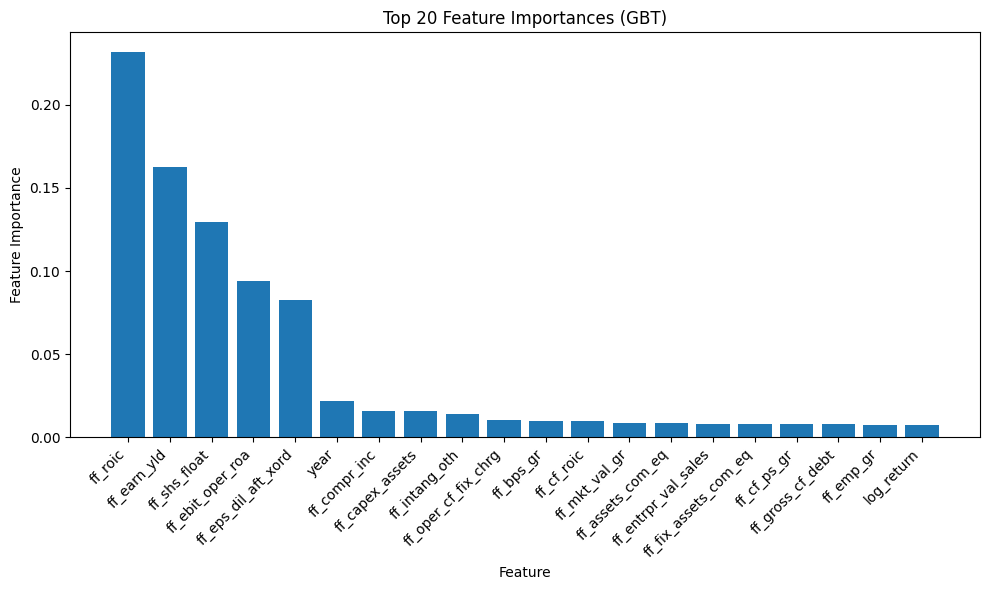

In [46]:
import numpy as np
#import pyspark.pandas as ps
from pyspark.sql.functions import lit,col
import pandas as pd
from pyspark.ml.feature import StandardScaler
from xgboost.spark import SparkXGBClassifier
#from boruta import BorutaPy
#from fredapi import Fred
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import  BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from CreateDataset import get_full_seqs, get_seq_means
from hyperopt import fmin, tpe, hp
from hyperopt.early_stop import no_progress_loss
from pyspark.mllib.evaluation import MulticlassMetrics
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
import math
from pyspark.ml.classification import FMClassifier
from hyperopt import SparkTrials, Trials
from sklearn.metrics import matthews_corrcoef

def t_t_split(df):
    split_date = "2019-01-01"

    # Step 3: Filter DataFrame to create train and test sets
    train_df = df.filter(col("end_date") < split_date)
    test_df = df.filter(col("end_date") >= split_date)
    train_label_1_count = train_df.filter(col("label") == 1).count()
    test_label_1_count = test_df.filter(col("label") == 1).count()
    
    # Printing the counts
    print("Length of train/test: ", train_df.count()/(train_df.count() + test_df.count()))
    print("Train DataFrame - Number of rows where label=1:", train_label_1_count)
    print("Test DataFrame - Number of rows where label=1:", test_label_1_count)
    
    return train_df, test_df


def write_results(report, mcc, best_params, filename):
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_params))


def feat_analysis(model, features, classifier_name):
    feature_importances = model.featureImportances
    feature_importances = feature_importances.toArray()
    sorted_idx = np.argsort(feature_importances)[::-1][:20]  # Selecting top 20 indices
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(sorted_idx)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"Top 20 Feature Importances ({classifier_name})")
    plt.tight_layout()
    plt.savefig(f'results_1yr/{classifier_name}_feature_importances.png')
    
    
def model_training(train_df, test_df, classifier):
    
    print("Number of records: ", train_df.count())
    
    features = [c for c in train_df.columns if c!='fsym_id' and c!='date' and c!='label']
    
    
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))

        return train_df
    
    def mcc(predictions):
        tp= predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
       # True Negatives
        tn= predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
       # False Positives
        fp= predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
       # False Negatives
        fn= predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
        if ((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))==0:
            return 0
        MCC = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))
        return MCC

     
    val_df = train_df.filter((col("date") >= "2017-01-01") & (col("date") < "2019-01-01"))
    train_df2 = train_df.filter((col("date") < "2017-01-01"))

    train_df2 = compute_weights(train_df2)
    val_df = compute_weights(val_df)
    train_df = compute_weights(train_df)

    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    train_df2 = vector_assembler.transform(train_df2)
    val_df = vector_assembler.transform(val_df)
    test_df = vector_assembler.transform(test_df)
    
    val_df_label_1_count = val_df.filter(val_df["label"] == 1).count()
    train_df_label_1_count = train_df2.filter(train_df2["label"] == 1).count()
    test_df_label_1_count = test_df.filter(test_df["label"] == 1).count()
    print("Number of instances in val_df where label=1:", val_df_label_1_count)
    print("Number of instances in train_df2 where label=1:", train_df_label_1_count)
    print("Number of instances in test_df where label=1:", test_df_label_1_count)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 100, 1),
            'maxDepth': hp.quniform('maxDepth', 3, 30, 1),
            'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1),
            'minInfoGain': hp.uniform('minInfoGain', 0.0, 1.0)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight', seed=42)
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 3, 30, 1),
            'maxBins': hp.quniform('maxBins', 16, 100, 1),
            'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1),
            'minInfoGain': hp.uniform('minInfoGain', 0.0, 1.0)
            
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight', seed=42)
        
    elif classifier == 'MLP':
        param_space = {
            'layers': hp.choice('layers', [ [len(features), len(features)//2, 2]]),
            'blockSize': hp.choice('blockSize', [128, 256]),
            'stepSize': hp.uniform('stepSize', 0.03, 0.3)
        }
        scaler = StandardScaler(inputCol="features_vector", outputCol="features_vector2", withStd=True, withMean=True)
        scaler_model = scaler.fit(train_df)
        train_df = scaler_model.transform(train_df)
        test_df = scaler_model.transform(test_df)
        
        classifier_instance = MultilayerPerceptronClassifier(layers=[len(features), len(features)//2, 2], seed=123, featuresCol='features_vector2', labelCol='label')
        # curr_model = classifier_instance.fit(train_df)
        # predictions = curr_model.transform(test_df)
        # val_metric = mcc(predictions)
        # print(val_metric)
        # return   
    elif classifier == 'XGB':
        param_space = {
            'eta': hp.uniform('eta', 0.01, 0.3),
            'max_depth': hp.quniform('max_depth', 3, 10, 1),
            'subsample': hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
            
        }
        classifier_instance =SparkXGBClassifier(features_col='features_vector', label_col='label', weight_col='weight', num_workers=2)
        
    elif classifier == 'FM':
        param_space = {
            'stepSize': hp.uniform('stepSize', 0.01, 1.0),
            'maxIter': hp.quniform('maxIter', 1, 100, 1),
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'factorSize': hp.quniform('factorSize', 4, 64, 1)
        }
        scaler = StandardScaler(inputCol="features_vector", outputCol="features_vector2", withStd=True, withMean=True)
        scaler_model = scaler.fit(train_df)
        train_df = scaler_model.transform(train_df)
        test_df = scaler_model.transform(test_df)
        classifier_instance = FMClassifier(featuresCol='features_vector2', labelCol='label')

    else:
        raise ValueError("Unsupported classifier")

    

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        curr_model = classifier_instance.fit(train_df2)
        predictions = curr_model.transform(val_df)
        val_metric = mcc(predictions)
        return curr_model, val_metric
 
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(10), trials = Trials())
    print("Best hyperparameters: ", best_params)
    classifier_instance.setParams(**best_params)
    best_model = classifier_instance.fit(train_df)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()

    
    final_report = classification_report(true, preds)
    print(final_report)
    mcc = matthews_corrcoef(true, preds)
    filename = f'results_1yr/report_{classifier}'
    write_results(final_report, mcc, best_params, filename)
    
    feat_analysis(best_model, features, classifier)
    
    return best_model, train_df, test_df
    
model, train_df, test_df = model_training(train_df_spark, test_df_spark, 'GBT')

In [67]:
for col in test_df.columns:
    if col not in train_df.columns:
        print(col)

Property/Casualty Insurance


In [65]:
test_df.columns

Index(['ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_oth_tot',
       'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets',
       'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr',
       ...
       'Steel', 'Telecommunications Equipment', 'Textiles', 'Tobacco',
       'Tools & Hardware', 'Trucking', 'Trucks/Construction/Farm Machinery',
       'Water Utilities', 'Wholesale Distributors',
       'Wireless Telecommunications'],
      dtype='object', length=194)

{0: 0.505421436723965, 1: 46.61323763955343}
Estimate: 92.226
 26%|██▌       | 26/100 [00:51<02:25,  1.97s/trial, best loss: -0.4201210844160047]
Best params:{'colsample_bytree': 0.25, 'eta': 0.4, 'gamma': 3.0500000000000003, 'max_depth': 1123.0, 'min_child_weight': 8.0, 'n_estimators': 160.0, 'scale_pos_weight': 319.9931973555463, 'subsample': 0.55}


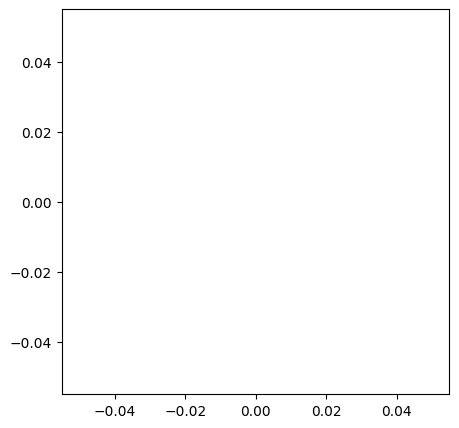

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21838
           1       0.10      0.18      0.13       175

    accuracy                           0.98     22013
   macro avg       0.55      0.58      0.56     22013
weighted avg       0.99      0.98      0.98     22013



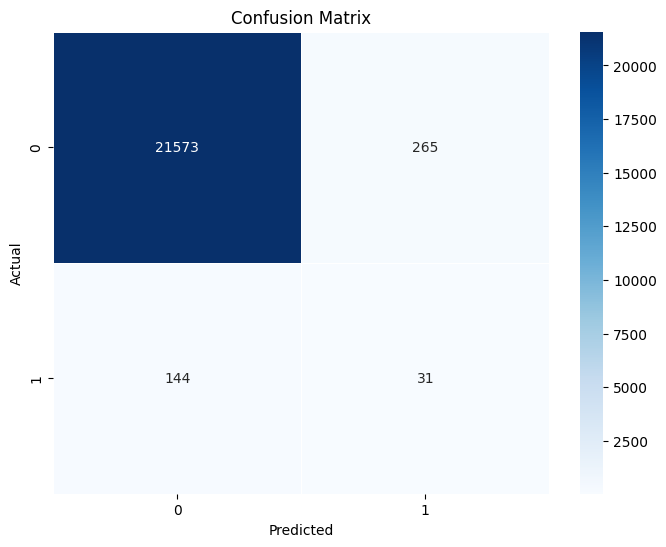

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce
# import lightgbm
import datetime
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef
import seaborn as sns

current_date = datetime.datetime.now()
current_date= current_date.strftime("%Y-%m-%d") 

def feature_importances(model, features, model_name):
    feature_importances = model.feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]  # Sorting in descending order
    top_features = sorted_idx[:20]  # Selecting top 20 features
    top_feature_importances = feature_importances[top_features]
    top_sorted_features = [features[i] for i in top_features]

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(top_features)), top_feature_importances, align="center")
    plt.xticks(range(len(top_features)), top_sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"All Feature Importances for {model_name}")
    plt.tight_layout()
    plt.savefig(f'results_1yr/{model_name}_feature_importances.png')
    plt.show()

    return top_sorted_features

def model_testing(train_df, test_df, classifier):
    seed = 42
    exclude_columns = ['fsym_id', 'label']
    
    train_df = train_df.set_index('date')
    test_df = test_df.set_index('date')
    train_df = train_df.sort_index()
    test_df = test_df.sort_index()
    
    train_df2 = train_df[train_df.index < '2017-01-01']
    X_train2 = train_df2.drop(exclude_columns, axis=1)
    y_train2 = train_df2['label']
    
    val_df = train_df[(train_df.index >= '2017-01-01') & (train_df.index < '2019-01-01')]
    X_val = val_df.drop(exclude_columns, axis=1)
    y_val = val_df['label']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', random_state=seed)
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        X_test[feats] = scaler.transform(X_test[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
            'max_depth': hp.quniform('max_depth', 5, 1200, 1),
            'max_features': hp.choice('max_features', [ 'sqrt','log2', None]),
            'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=seed)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',10,500,1),
                        'max_depth':hp.quniform('max_depth',5,1200,1),
                       'eta': hp.quniform('eta', 0.025, 1, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 5, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.05),
                       'scale_pos_weight' : hp.uniform('scale_pos_weight', 0, 500)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(scale_pos_weight=estimate, seed=seed)
    else:
        raise ValueError("Unsupported classifier")
        
    tscv = TimeSeriesSplit(n_splits=3)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        classifier_instance.fit(X_train2, y_train2)
        # scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='matthews_corrcoef')
        y_pred = classifier_instance.predict(X_val)
        score = matthews_corrcoef(y_val, y_pred)
        # obj_scores.append(score)
        return -score

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        # res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(20))
    print(f"Best params:{best_params}")
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    all_reports = []
    plt.figure(figsize=(5,5))
    plt.plot(obj_scores)
    plt.show()
    
    classifier_instance.fit(X_train, y_train)
    preds = classifier_instance.predict(X_test)
    final_report = classification_report(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    
    print(final_report)
    
    write_results(final_report, mcc, best_params, f'results_1yr/report_{classifier}')
    

    cm = confusion_matrix(y_test, preds, labels=classifier_instance.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    test_df_full = test_df.copy()
    test_df_full['preds'] = preds

    return classifier_instance, X_train.columns.tolist(), X_train, X_test, test_df_full


model, feats, X_train, X_test, test_df_with_preds = model_testing(train_df, test_df, 'XGB')

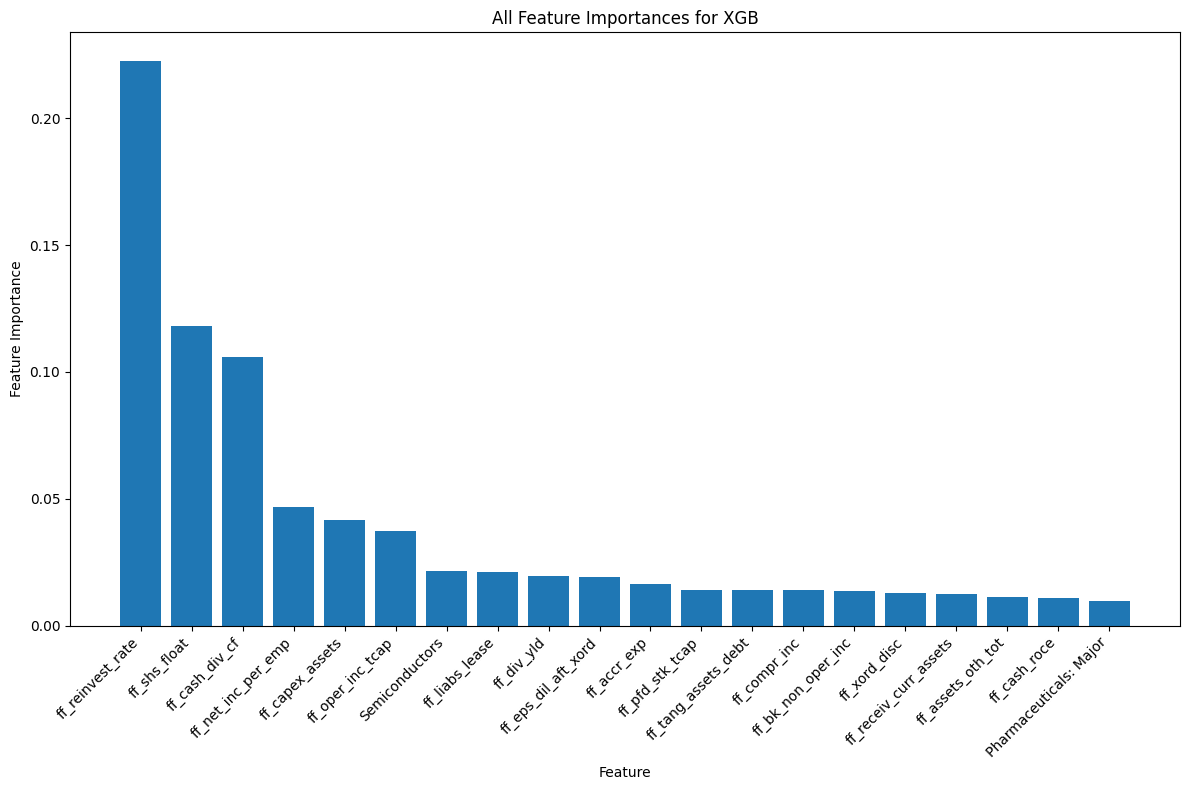

In [56]:
feats_to_drop = feature_importances(model,feats, 'XGB')
# train_df2 = train_df.drop(feats_to_drop, axis=1)
# test_df2 = test_df.drop(feats_to_drop, axis=1)
# model2, feats2, _,_,_ = model_testing(train_df2, test_df2, 'XGB')

In [34]:
_ = feature_importances(model2,feats2)

NameError: name 'model2' is not defined

In [66]:
len(X_train.columns)

64

 99%|===================| 21767/22013 [00:55<00:00]        

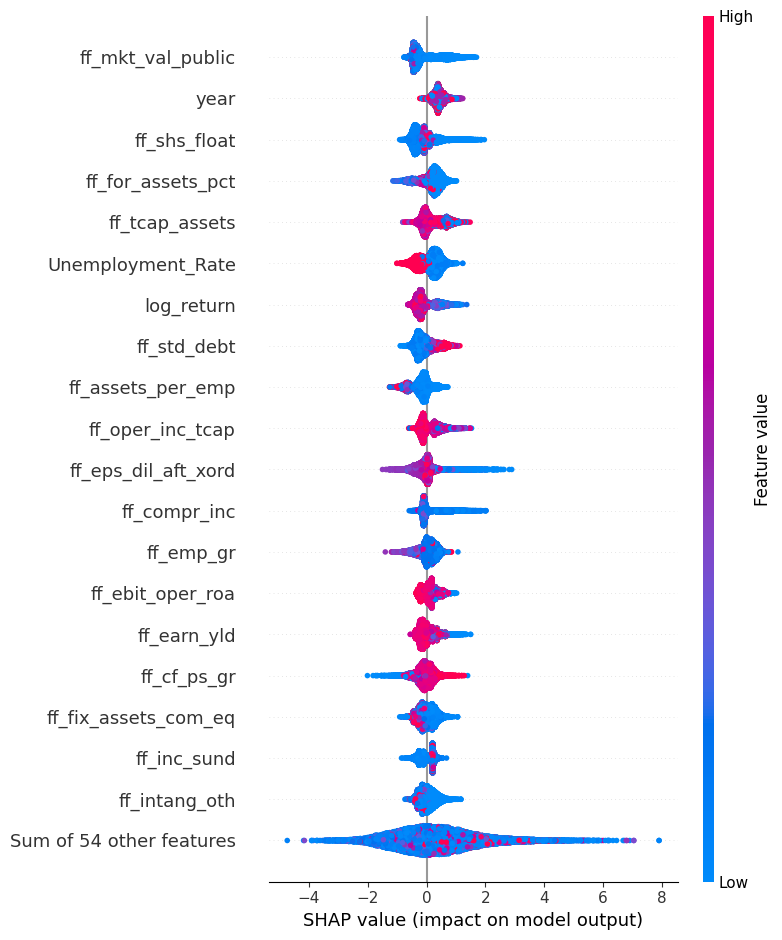

In [58]:
import shap


def shapley(model, train, test, model_name, plot_type):
    # train = train.toPandas()
    # test=test.toPandas()
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model,train)
    shap_values = explainer(test)
    shap.initjs()
    # print(shap_values.shape)
    # shap.plots.beeswarm(shap_values)
    # shap.summary_plot(shap_values,test,show=False)
    if plot_type == 'bar':
        shap.plots.bar(shap_values, max_display=20, show=False)
    elif plot_type == 'beeswarm':
        shap.plots.beeswarm(shap_values, max_display=20, show=False)
        
    plt.tight_layout()
    plt.savefig(f'results_1yr/{model_name}_shap_{plot_type}.png')
    
    
# shapley(model, train_df, test_df, model_name='rf')
    
shapley(model, X_train, X_test, 'XGB', 'beeswarm')

In [45]:
train_df.head()

,index,fsym_id,ff_accr_exp,ff_assets_com_eq,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_fix_assets,ff_cash_curr_assets,...,ff_std_debt,ff_bk_oper_inc_oth,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,GDP,Unemployment_Rate,label
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,48976,GJZ5YB-R,143.784000,1.729254,42.422,0.067783,40.774170,21.456759,38.323007,2.935040,...,16.327238,0.0,418.805,0.0,6.031711,47.160,258.142,0.011395,3.9,0
2000-01-31,87865,GSXP1N-R,6.019841,1.194269,0.000,0.184405,17.212545,2.732302,25.527204,70.773903,...,0.000000,0.0,0.000,0.0,-23.401890,0.000,14.350,0.011395,3.9,0
2000-01-31,70510,WPKF66-R,389.953000,2.733014,81.397,0.054461,4.659683,12.656485,33.016331,33.537477,...,51.517129,0.0,534.159,0.0,68.939663,0.018,570.000,0.011395,3.9,0
2000-01-31,89899,LWY6TY-R,6.947000,1.902163,1.656,0.276648,29.050884,6.648226,14.881759,14.276476,...,6.672323,0.0,0.000,0.0,5.554106,0.000,28.144,0.011395,3.9,0
2000-01-31,38583,BZNBHW-R,29.544000,2.373729,4.166,0.092724,-6.072055,5.046265,6.617032,3.564810,...,5.623622,0.0,0.000,0.0,7.655820,0.000,-7.665,0.011395,3.9,0


In [94]:
from sklearn.ensemble import IsolationForest

def anomaly_det(train_df, test_df):
    train_df = train_df.reset_index()
    test_df = test_df.reset_index()
    exclude_columns = ['fsym_id', 'label', 'date']
    features = train_df.drop(exclude_columns, axis=1).columns
    print("Converted to Pandas")
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df.set_index('date', inplace=True)
    train_df.sort_index(inplace=True)
    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df.set_index('date', inplace=True)
    test_df.sort_index(inplace=True)
    contam = len(train_df[train_df['label']==1])/len(train_df)
    isol_for = IsolationForest(contamination=contam, random_state=42)
    non_anomalies = train_df[train_df['label']==0]
    isol_for.fit(non_anomalies[features])
    test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
    test_df['anomaly'] = isol_for.predict(test_df[features])
    test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)
    print(f"Classification Report: ")
    print(classification_report(test_df['label'], test_df['preds']))
    cm = confusion_matrix(test_df['label'], test_df['preds'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
# anomaly_det(train_df, test_df)

{0: 0.5055204769127659, 1: 45.78594249201278}
52130 499 5194 127
0.009664736301834169
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1057 (4.13 KB)
Trainable params: 1057 (4.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
163/163 [==============================] - 0s 2ms/step - loss: 0.3566 - cross entropy: 0.3566 - Brier score: 0.0863 - tp: 92.0000 - fp: 561.0000 - tn: 4506.0000 - fn: 35.0000 - accuracy: 0.8853 -

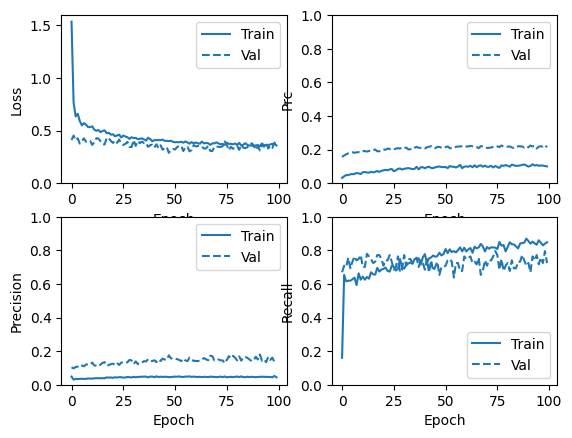

In [91]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Generate some dummy time series data


# Define the number of folds for cross-validation

def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def plot_metrics(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':#
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
    
def plot_loss(history, label, n):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

def nn_training(df):
    df=df.set_index('date')
    df=df.sort_index()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    seed = 42
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']

    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)
    }
    
    METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    
    def make_model(train_features, metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
            
        model = keras.Sequential([
              keras.layers.Dense(
                  16, activation='relu',
                  input_shape=(train_features.shape[-1],)),
              keras.layers.Dropout(0.5),
              keras.layers.Dense(1, activation='sigmoid',
                                 bias_initializer=output_bias),
          ])
   
        
        model.compile(
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=metrics)
        return model
    
    def get_preds(model, feats, truth):
        predictions = model.predict(feats, batch_size = 2048)
        print(predictions)
        for i in range(len(predictions)):
            predictions[i] = 1 if predictions[i] >= 0.5 else 0
        print(classification_report(truth, predictions))
    
    
    
#     model = tf.keras.Sequential([
#         tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
#         tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
#         tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    split_date = '2020-01-01'
    train_index = X.index < split_date
    test_index = X.index >= split_date


    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    
    print(len(y_train), len(y_train[y_train==1]), len(y_test), len(y_test[y_test==1]))

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    pos = len(y_train[y_train==1])
    neg = len(y_train[y_train==0])
    print(pos/neg)
    initial_bias = np.log([pos/neg])

    model = make_model(X_train, output_bias=initial_bias)
    print(model.summary())

    fit_model = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data = (X_test, y_test), class_weight = class_weight_dict, 
                        
                         verbose=0)
    # plot_model_performance(fit_model, 'bin_cross_entropy', 'accuracy')
    plot_metrics(fit_model)
    # plot_loss(fit_model, "Train Loss", 0)

    results = model.evaluate(X_test, y_test)
    print(f'Test loss: {results[0]}')

    # Make predictions on new data
    get_preds(model, X_train, y_train)
    get_preds(model, X_test, y_test)
        

#     cm = confusion_matrix(y_test, predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
#     plt.title(f'Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()


    
nn_training(df)

In [59]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score

# Define the search space for hyperparameters

def hyperopt_nn(train_df, test_df):
    train_df = train_df.set_index('date')
    train_df = train_df.sort_index()
    test_df = test_df.set_index('date')
    test_df = test_df.sort_index()
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512, 1024, 2048, 4096]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'class_weight_0': hp.uniform('class_weight_0', 0.1, 5),  
        'class_weight_1': hp.uniform('class_weight_1', 0.1, 100) 
    }

    scaler=StandardScaler()
    X_train = train_df.drop(['fsym_id', 'label'], axis=1)
    X_val = test_df.drop(['fsym_id', 'label'], axis=1)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    y_train = train_df['label']
    y_val = test_df['label']
    
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weight_dict = dict(enumerate(class_weights))
    # print(class_weight_dict)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
        y_true = tf.cast(y_true, tf.float32)
      
        ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))

        focal_loss = -alpha * (1 - p_t) ** gamma * ce_loss

        return tf.reduce_mean(focal_loss)

    # Objective function to minimize
    def train_with_params(params):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0 )
        for i in range(len(preds)):
            preds[i] = 1 if preds[i] >= 0.5 else 0
            
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096, 8192][best['batch_size']],
        'num_layers': [2, 3, 4, 5][best['num_layers']],
        'num_neurons': [128, 256, 512, 1024, 2048][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'class_weight_0': best['class_weight_0'],
        'class_weight_1': best['class_weight_1']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5 else 0
    final_report = classification_report(y_val, preds)
    mcc = matthews_corrcoef(y_val, preds)
    filename = f'results_1yr/report_mlp_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_hyperparams))
    
hyperopt_nn(train_df, test_df)

 20%|██        | 10/50 [04:49<19:17, 28.94s/trial, best loss: -0.15869893102335117]
Best hyperparameters: {'learning_rate': 0.0002285218513755167, 'batch_size': 1024, 'num_layers': 3, 'num_neurons': 1024, 'dropout_rate': 0.21485165660771427, 'class_weight_0': 3.033787140891156, 'class_weight_1': 25.016817990237794}
Best metric: 0.17037397432892515
22/22 [==============================] - 0s 7ms/step
[[4.1308776e-06]
 [1.4440506e-04]
 [1.4889110e-03]
 ...
 [1.7725746e-03]
 [5.9555240e-02]
 [5.9356846e-02]]


In [1]:
from CreateDataset import get_fund_data
import math
from datetime import datetime, timedelta

def plot_prices(imp_df, pic_name):
    imp_df=imp_df.sort_values(by=['fsym_id', 'date'])
    imp_df['date'] = pd.to_datetime(imp_df['date'])
    list_to_plot = sorted(imp_df['fsym_id'].unique().tolist())
    
    columns = 5
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = imp_df[imp_df['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)
        
        imp_start_date = temp_df['Implosion_Start_Date'].iloc[0]
        imp_end_date = imp_start_date + timedelta(days=365)
        
        if imp_start_date is not None:
            # filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            # vol = filtered_temp_df['split_adj_price'].std()
            # imp_start_date = pd.to_datetime(imp_start_date)
            # imp_end_date = pd.to_datetime(imp_end_date)
            #filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            #print(filtered_temp_df.head())
            axs[i].axvspan(imp_start_date, imp_end_date, alpha=0.5, color='blue')
        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig(pic_name)


def plot_true_false_positives(test_df, square, model_name):
    if square == 'FP':
        df = test_df[(test_df['label'] == 0) & (test_df['preds'] == 1)]
        df=df[['fsym_id', 'date', 'label', 'preds']]
        df['Implosion_Start_Date'] = df['date']
        print(df.head())
        df_prices = get_fund_data(spark.createDataFrame(df))
        df_prices = df_prices.toPandas()
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        print(df_prices.head())
        df_combined = df_prices.merge(df[['fsym_id','Implosion_Start_Date']], on=['fsym_id'], how='left')
        plot_prices(df_combined, f'false_positives_{model_name}.png')
    elif square == 'FN':
        df = test_df[(test_df['label'] == 1) & (test_df['preds'] == 0)]
        df=df[['fsym_id', 'date', 'label', 'preds']]
        df['Implosion_Start_Date'] = df['date']
        print(df.head())
        df_prices = get_fund_data(spark.createDataFrame(df))
        df_prices = df_prices.toPandas()
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        print(df_prices.head())
        df_combined = df_prices.merge(df[['fsym_id','Implosion_Start_Date']], on=['fsym_id'], how='left')
        plot_prices(df_combined, f'false_negatives_{model_name}.png')
        

        

plot_true_false_positives(test_df_with_preds, 'FN', 'XGB')

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-02-18 14:09:14,822 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-02-18 14:09:17,854 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


NameError: name 'test_df_with_preds' is not defined

In [78]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import matthews_corrcoef
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.early_stop import no_progress_loss
import numpy as np

# Define the search space for hyperparameters
def hyperopt_rnn(df):
    df = df.set_index('date')
    df = df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [1, 2, 3]),
        'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'thresh': hp.uniform('thresh', 0, 1)
    }
    
    split_date = '2020-01-01'
    train_index = X.index < split_date
    test_index = X.index >= split_date

    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    print(len(X_train) / len(X))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Objective function to minimize
    def train_with_params(params):
        model = tf.keras.Sequential()
        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.LSTM(params['num_neurons'], return_sequences=True))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))
        model.add(tf.keras.layers.LSTM(params['num_neurons']))
        model.add(tf.keras.layers.Dropout(params['dropout_rate']))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=params['batch_size'], epochs=10, class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)
        
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0)
        preds = (preds >= params['thresh']).astype(int)
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric

    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096][best['batch_size']],
        'num_layers': [1, 2, 3][best['num_layers']],
        'num_neurons': [64, 128, 256][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'thresh': best['thresh']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size=best_hyperparams['batch_size'])
    preds = (preds >= best_hyperparams['thresh']).astype(int)
    print(classification_report(y_val, preds))
    
# Example usage
# hyperopt_rnn(df)


In [ ]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    
    tscv = TimeSeriesSplit(n_splits=5)
    seed = 42
    df=df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    X_train = df.drop(exclude_columns, axis=1)
    Y_train = df['label']
    
    features = X_train.columns[:-1]
    print(len(features))
    
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        num_pos = len(y_train[y_train == 1])
        print(num_pos/len(y_train))
        isol_for = IsolationForest(contamination=num_pos/len(y_train), random_state=42)

        isol_for.fit(x_train[features])

        train_df = x_train.copy()  # Create a copy of the training set for results
        test_df = x_test.copy()    # Create a copy of the test set for results

        train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
        train_df['anomaly'] = isol_for.predict(train_df[features])
        train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)

        test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
        test_df['anomaly'] = isol_for.predict(test_df[features])
        test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)

        print(f"Classification Report: ")
        print(classification_report(y_test, test_df['preds']))
        # cm = confusion_matrix(y_test, test_df['preds'])
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        
   

    
    
    
# anomaly_det(df2)

In [ ]:
def shapley(model, train, test):
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model)
    shap_values = explainer(train)
    shap.initjs()
    print(shap_values.shape)
    shap.plots.waterfall(shap_values[0])
    
shapley(model2, X_train2, None)

In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
# gbt_feats = boruta_fs(df, 'gbt')

### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()